In [1]:
import glob
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [2]:
def get_images_from_path(path):
    images = [cv2.imread(image, cv2.IMREAD_GRAYSCALE) for image in glob.glob(path + '/*.jpg')]
    return images

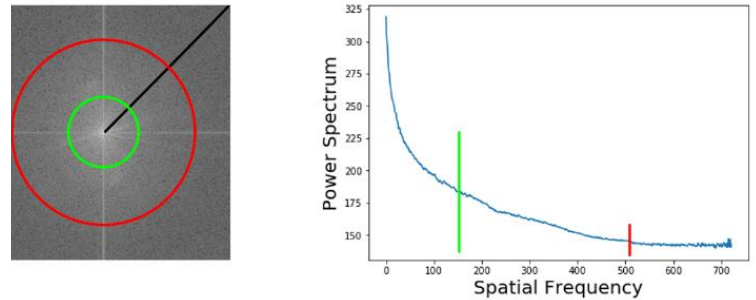

In [3]:
def get_max_radius(size):
    # Get the center
    center = int((size - 1)/2)
    
    # Pythagoras
    return int(np.sqrt(center**2 + center**2))

In [4]:
def get_radial_points(radius_size):
    """
    The function returns an array of lists.
    The array size is defined by a given radius size.
    Each list within a cell contains points that are set by the cell's index+1.
    Every cell's index+1 represents a radius within the image. 
    Points that were placed inside a list are cloesest to the radius_size = index+1.
    """
    radius_max = radius_size + 1
        
    radial_points = []
    
    # Iterate through all of the radiuses within the image.
    for radius in range(1, radius_max):
        points_current = []
        radius_previous = radius - 1
        
        # Get all possible points within a circle.
        for (X, Y) in product(range(radius + 1), repeat=2):
            # Cancel out points that aren't between the last and current radius.
            if radius_previous**2 < X**2 + Y**2 <= radius**2:
                # Add similar points from different quadrants.
                points_current += list(set(((X, Y), (-X, Y), (-X, -Y), (X, -Y))))
             
        # Append all current radius points to the list.
        radial_points.append(points_current)
        
    return radial_points

In [5]:
def get_azimuthal_average(image, radial_points, radius_max):
    """
    Calculate the azimuthally averaged radial profile.
    Turn a 2D image to 1D.
    """
    azimuthal_average = np.zeros(radius_max)
    
    # Run through all radiuses.
    for radius in range(radius_max):
        # Run through all the points within a radius
        for (X, Y) in radial_points[radius]:
            azimuthal_average[radius] += image[X, Y]
            
        # Dividing by the amount of points within a radius to recieve the average.
        azimuthal_average[radius] /= len(radial_points[radius])
        
    return azimuthal_average

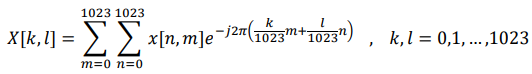

In [6]:
def extract_properties(images):
    radius_max = get_max_radius(len(np.fft.fft2(images[0])))
    radial_points = get_radial_points(radius_max)
    
    as1D = np.zeros((len(images), radius_max))

    for i in range(len(images)):
        # X[k][l] = x[n][m]*np.exp(-2j*np.pi*(k*m/1023 + l*n/1023))
        x = np.fft.fft2(images[i])
        
        # Centering X[0, 0]
        x = np.fft.fftshift(x)
        
        # Preventing numerical problems
        x += 1e-8
        
        # Calculating the magnitude
        x = 20*np.log(np.abs(x))
            
        as1D[i] = get_azimuthal_average(x, radial_points, radius_max)
    
    return as1D

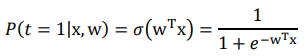

In [7]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

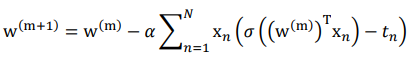

In [8]:
def gradient_descent(x, t, a, w0, number_of_iterations):
    w = np.zeros((number_of_iterations, len(w0)))
    w[0, :] = w0[:]
    
    learning_sum = 0
        
    for m in range(number_of_iterations - 1):
        for n in range(len(x)):
            z = w[m].T@x[n]
            learning_sum += x[n]*(sigmoid(z) - t[n])
      
        w[m + 1] -= a*learning_sum
                           
    return w

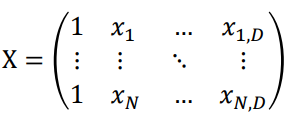

In [9]:
def add_ones_columns(x):
    X = np.ones((len(x), len(x[0]) + 1))
    X[:,1:] = x
    
    return X

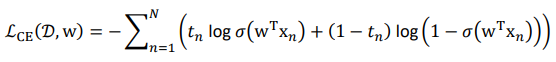

In [10]:
def get_cross_entropy(x, w, t):
    """
    Loss Function - Logarithmic loss
    """
    cross_entropy = 0
    
    for n in range(len(x)):
        z = w.T@x[n]
        cross_entropy -= (t[n]*np.log(sigmoid(z)) + (1 - t[n])*np.log(1 - sigmoid(z)))
        
    return cross_entropy

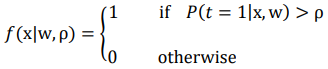

In [11]:
def get_classifier_decision(x, w, p):
    z = w.T@x
    return 1 if sigmoid(z) > p else 0

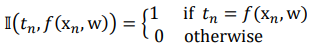

In [12]:
def get_indicator(x, w, t, p):
    return 1 if t == get_classifier_decision(x, w, p) else 0

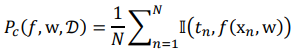

In [13]:
def get_classifier_accuracy(x, w, t, p):
    classifier_accuracy = 0
    N = len(x)
    
    for n in range(N):
        classifier_accuracy += get_indicator(x[n], w, t[n], p)
        
    classifier_accuracy *= (1/N)
            
    return classifier_accuracy

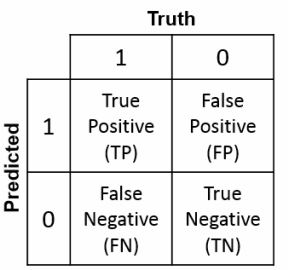

In [14]:
def get_confusion_matrix(x, w, t, p):
    classifier_decision = np.zeros(len(x))
    
    for n in range(len(x)):
        classifier_decision[n] = get_classifier_decision(x[n], w, p)
        
    confusion_matrix_data = confusion_matrix(t, classifier_decision)
        
    return confusion_matrix_data

In [15]:
def draw_confusion_matrix(cm, set_type):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=cm[i, j], va='center', ha='center', size='xx-large')
     
    plt.xlabel('Predicted', fontsize=18)
    plt.ylabel('Truth', fontsize=18)
    plt.title('Confusion Matrix ' + str(set_type), fontsize=18)
    plt.show()

In [16]:
def draw_accuracy_vs_GD_step(m ,classifier_accuracy, set_type):
    plt.plot(range(m), classifier_accuracy[:])
    plt.xlabel('Gradient Descent Step Index')
    plt.ylabel('Accuracy')
    plt.title(str(set_type) + ' Classifier Accuracy vs ' + str(m) + ' Gradient Descent Update Steps')
    plt.show()

In [17]:
def draw_cross_entropy_vs_GD_step(m ,cross_entropy, set_type):
    plt.plot(range(m), cross_entropy[:])
    plt.xlabel('Gradient Descent Step Index')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(str(set_type) + ' Cross Entropy vs ' + str(m) + ' Gradient Descent Update Steps')
    plt.show()

In [18]:
def draw_ROC(number_of_steps, cm, set_type):
    # Confusion Matrix[0, 0] - TN
    # Confusion Matrix[0, 1] - FP
    # Confusion Matrix[1, 0] - FN
    # Confusion Matrix[1, 1] - TP
    false_positive_rate = np.zeros(number_of_steps- 1)
    true_positive_rate = np.zeros(number_of_steps-1)
    
    for m in range(1, number_of_steps):
        false_positive = cm[m][0, 1]
        true_positive = cm[m][1, 1]
        
        denominator = false_positive + true_positive
        
        false_positive_rate[m-1] = false_positive/denominator
        true_positive_rate[m-1] = true_positive/denominator
    
    plt.plot(false_positive_rate[:], true_positive_rate[:])
    plt.xlabel('False Positive Ratio')
    plt.ylabel('True Positive Ratio')
    plt.title(str(set_type) + ' Roc curve after ' + str(number_of_steps) + ' Gradient Descent Update Steps')
    plt.show()

In [19]:
def initialize_validation_classifier():
    # Get all images from stated directory.
    images_fake = get_images_from_path('TrainData/Fake')
    images_real = get_images_from_path('TrainData/Real')
    
    # Create one list for all images.
    images_all = images_fake + images_real
    pictures_amount = len(images_all)
    
    # Set true and false for each image.
    y = np.ones(len(images_all))
    y[len(images_fake):] = 0
    
    # Extract properties from all images by turning them from 2D to 1D.
    as1D = extract_properties(images_all)
    
    x = add_ones_columns(as1D)

    # Cross validation with 3 folds -> train = 0.66, validation = 0.34
    x_1 = x[range(int(pictures_amount*(2/6)))]
    x_2 = x[range(int(pictures_amount*(2/6)), int(pictures_amount*(3/6)))]
    x_3 = x[range(int(pictures_amount*(3/6)), int(pictures_amount*(5/6)))]
    x_4 = x[range(int(pictures_amount*(5/6)), pictures_amount)]
    
    y_1 = y[range(int(pictures_amount*(2/6)))]
    y_2 = y[range(int(pictures_amount*(2/6)), int(pictures_amount*(3/6)))]
    y_3 = y[range(int(pictures_amount*(3/6)), int(pictures_amount*(5/6)))]
    y_4 = y[range(int(pictures_amount*(5/6)), pictures_amount)]
    
    x_train = np.concatenate((x_1, x_3))
    x_validation =  np.concatenate((x_2, x_4))
    
    y_train = np.concatenate((y_1, y_3))
    y_validation =  np.concatenate((y_2, y_4))
    
    # Setting constants, three different options were found.
    learning_rate = 1e-10 #1e-9 #58e-10
    number_of_updates = 1000 #5000 #2000 
    threshold = 0.5
    
    w0 = np.zeros(len(x[0]))
    
    w = gradient_descent(x_train, y_train, learning_rate, w0, number_of_updates)

    # Set memeory for cross-entropy, classifier accruacy, and confusion matrix.
    cross_entropy_train = np.zeros(number_of_updates)
    
    classifier_accuracy_train = np.zeros(number_of_updates)    
    classifier_accuracy_validation = np.zeros(number_of_updates)
    
    cm_train = np.zeros((number_of_updates, 2, 2))
    cm_validation = np.zeros((number_of_updates, 2, 2))
    
    # Calculate cross-entropy, classifier accuracy, and confusion matrix for each gradient descent step.
    for m in range(number_of_updates):
        cross_entropy_train[m] = get_cross_entropy(x_train, w[m], y_train)
        
        classifier_accuracy_train[m] = get_classifier_accuracy(x_train, w[m], y_train, threshold)
        classifier_accuracy_validation[m] = get_classifier_accuracy(x_validation, w[m], y_validation, threshold)
        
        cm_train[m] = get_confusion_matrix(x_train, w[m], y_train, threshold)
        cm_validation[m] = get_confusion_matrix(x_validation, w[m], y_validation, threshold)   
        
    # Draw all graphs
    draw_cross_entropy_vs_GD_step(number_of_updates, cross_entropy_train, 'Training')
    
    draw_accuracy_vs_GD_step(number_of_updates ,classifier_accuracy_train, 'Training')
    draw_accuracy_vs_GD_step(number_of_updates ,classifier_accuracy_validation, 'Validation')
    
    draw_confusion_matrix(cm_train[number_of_updates - 1], 'Training')
    draw_confusion_matrix(cm_validation[number_of_updates - 1], 'Validation')
    
    draw_ROC(number_of_updates, cm_train, 'Training')
    draw_ROC(number_of_updates, cm_validation, 'Validation')

In [22]:
def initialize_test_classifier():
    # Get all images from stated directory.
    images_fake = get_images_from_path('TrainData/Fake')
    images_real = get_images_from_path('TrainData/Real')
    
    images_train = images_fake + images_real
    
    file_name = []
    images_test = []
    
    # Get all images from directory and save image name.
    for image in glob.glob('FutureData/*.jpg'):
        file_name.append(image.replace('FutureData\\', ''))
        images_test.append(cv2.imread(image, cv2.IMREAD_GRAYSCALE))
    
    # Set true and false for each image.
    y_train = np.ones(len(images_train))
    y_train[len(images_fake):] = 0
    
    # Extract properties from all images by turning them from 2D to 1D.
    as1D_train = extract_properties(images_train)
    x_train = add_ones_columns(as1D_train)
    
    as1D_test = extract_properties(images_test)
    x_test = add_ones_columns(as1D_test)
    
    w0 = np.zeros(len(x_train[0]))
    
    # Setting constants.
    learning_rate = 1e-10
    number_of_updates = 1000
    threshold = 0.5
    
    w = gradient_descent(x_train, y_train, learning_rate, w0, number_of_updates)
    
    classifier_decision = np.zeros(len(x_test))
    
    # Validating image authenticity.
    for n in range(len(x_test)):
        classifier_decision[n] = get_classifier_decision(x_test[n], w[number_of_updates -1], threshold)
    
    # Writing data to a file.
    file = open('FutureDataEstimatedLabels', 'w', encoding='UTF8', newline='')
    writer = csv.writer(file)
    writer.writerow(['File Name   Classifier Data'])
    
    for n in range(len(file_name)):
        writer.writerow([str(file_name[n]) + '     ' + str(classifier_decision[n])])
        
    file.close()

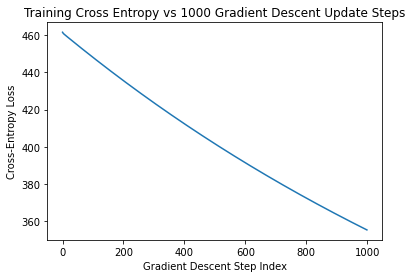

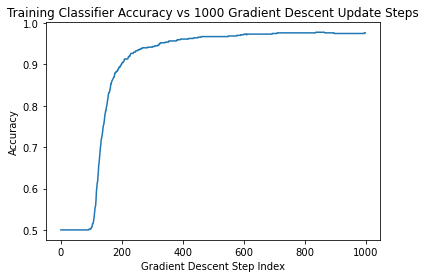

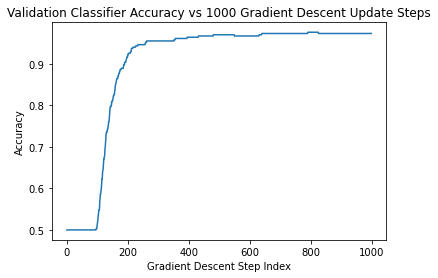

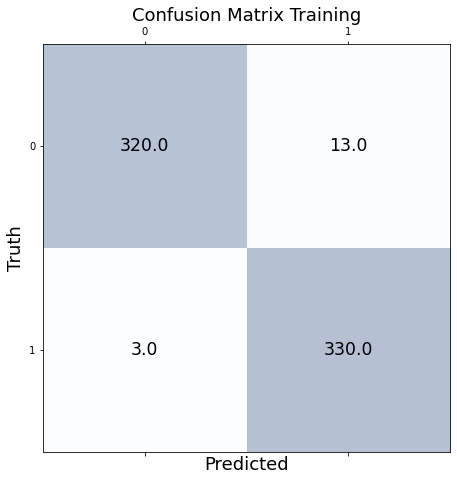

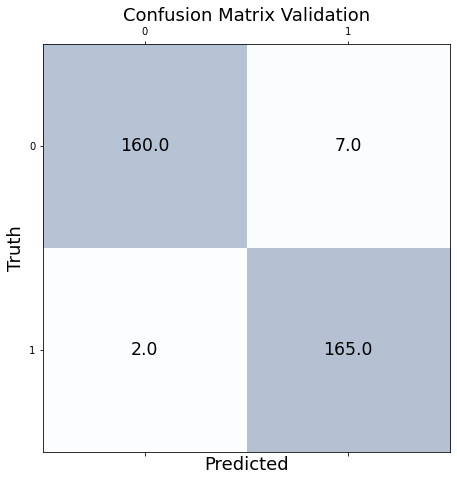

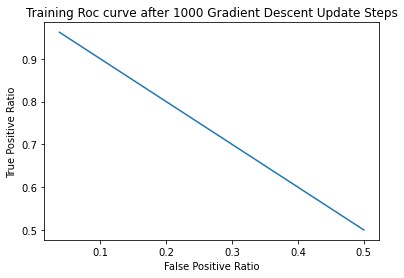

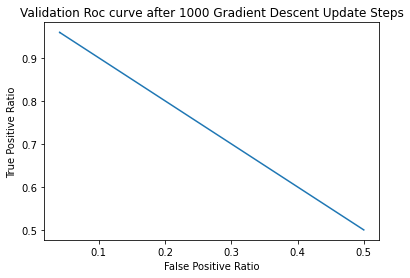

In [21]:
initialize_validation_classifier()

In [23]:
initialize_test_classifier()